In [1]:
import pandas as pd
import os, json, sys, subprocess
from numpy import nan
import numpy as np
from statistics import median
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
DATA_CONVERGE_PROJECT="sd2e-project-43/test/batch_20200525"
base_dir = os.path.join(os.path.expanduser("~"), 'sd2e-projects')
RESULTSDIR = "../../flow_cytometry_scoring/notebooks/20200617"

In [3]:
# Local results file handling

datetime = subprocess.check_output(['date +%Y_%m_%d_%H_%M_%S'],shell=True).decode(sys.stdout.encoding).strip()
results_dir = os.path.expanduser(RESULTSDIR)
results_dir_contents = [os.path.realpath(os.path.join(results_dir, x)) for x in os.listdir(results_dir) if "summary" not in x]
results_dir_short = sorted([r for r in results_dir_contents if "Short" in r])

results_dir_short

['/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_etl_stats_wasserstein_dists.csv',
 '/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv',
 '/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032_fc_etl_stats_wasserstein_dists.csv',
 '/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032_fc_raw_log10_stats_wasserstein_dists.csv']

In [4]:
# Metadata file handling

exps = [r.split("/") for r in results_dir_short]
experiments = [e.split("_fc")[0] for le in exps for e in le if e.startswith("dc_")]
meta_files = []
for experiment in experiments:
    exp_path = os.path.join(base_dir,DATA_CONVERGE_PROJECT,experiment)
    for fname in os.listdir(exp_path):
        if fname.endswith("_fc_meta.csv"): 
            meta_files.append(os.path.realpath(os.path.join(exp_path,fname)))

meta_files

['/home/jupyter/sd2e-projects/sd2e-project-43/test/batch_20200525/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800/YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/batch_20200525/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800/YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/batch_20200525/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032/YeastSTATES-CRISPR-Short-Duration-Time-Series-35C__fc_meta.csv',
 '/home/jupyter/sd2e-projects/sd2e-project-43/test/batch_20200525/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032/YeastSTATES-CRISPR-Short-Duration-Time-Series-35C__fc_meta.csv']

In [5]:
# Helper functions

def load_csv(fname):
    # for both results and combined metadata df
    return pd.read_csv(fname)

def group_me(df,columns):
    # for metadata df
    return df.groupby(columns)

def get_samp_id_order(df):
    # for results df
    return list(df.columns)[1:]

def get_matrix(df):
    #for results df
    return df.values

def get_samp_ids(df,col,value):
    # for group in grouped metadata df
    df2 = df[df[col] == value]
    return df2["sample_id"].values

def get_index_pair_value(results,samp_id_order,id1,id2):
    # for results matrix from results df
    ind1 = samp_id_order.index(id1)
    ind2 = samp_id_order.index(id2)
    return results[ind1,ind2]
    

In [6]:
def compute_difference(results_file, metadata_file, columns, comparison_column, comparison_values):
    '''
    results_file = Wasserstein results
    metadata_file = csv with merged metadata columns
    columns = columns to groupby (probably strain, BE conc, and rep)
    comparison_column = column containing the two values to compare
    comparison_values = 2 vector with a start value and an end value
    threshold_10_fold = number above which a minimum of a 10-fold difference is detected (i.e. may want to choose 9.5 instead of 10)
    '''
    meta_df = load_csv(metadata_file)
    meta_grouped = group_me(meta_df,columns)
    res_df = load_csv(results_file)
    samp_id_order = get_samp_id_order(res_df)
    results = get_matrix(res_df)[:,1:]
    values = {}
    missing = []
    for name,group in meta_grouped:
        initial_ids = get_samp_ids(group,comparison_column,comparison_values[0])
        final_ids = get_samp_ids(group,comparison_column,comparison_values[1])
        group_vals = []
        pairs = []
        for samp_id_init in initial_ids:
            for samp_id_fin in final_ids:
                try: 
                    val = get_index_pair_value(results,samp_id_order,samp_id_init,samp_id_fin)
                except:
                    # handle dropped samples in ETL
                    # print("One of the two sample ids {} not found.".format([samp_id_init,samp_id_fin]))
                    val = nan                        
                group_vals.append(val)
                pairs.append((samp_id_init,samp_id_fin))
        if group_vals:
            values[name] = [min(group_vals),median(group_vals),max(group_vals),pairs]
        else:
            missing.append(name)
    summary = pd.DataFrame.from_dict(values, orient='index',columns=['wasserstein_min','wasserstein_median','wasserstein_max','sample_ids'])
    return summary,missing
        
                

In [7]:
def save_summary(summary,fname):
    summary.to_csv(fname)
    
def save_params(params,fname):
    json.dump(params,open(fname,"w"))
    
def compute_summary(results_dir_contents, meta_files, groupby_columns, comparison_column, comparison_values,identifier = "_time_diff_"):
    all_summaries = {}
    for results_file,metadata_file in zip(results_dir_contents,meta_files):
        summary,_ = compute_difference(results_file, metadata_file, groupby_columns, comparison_column, comparison_values)
        #fname = results_file.split(".")[0] + identifier + "summary_" + datetime + ".csv"
        fname = results_file.split("/")[-1].split(".")[0] + identifier + "summary_" + datetime + ".csv"
        save_summary(summary,fname)
        params = {"results_file" : results_file, "metadata_file" : metadata_file, "groupby_columns" : groupby_columns, "comparison_column" : comparison_column,  "comparison_values" : comparison_values }
        #fname = results_file.split(".")[0] + identifier + "params_" + datetime + ".csv"
        fname = results_file.split("/")[-1].split(".")[0] + identifier + "params_" + datetime + ".csv"
        save_params(params,fname)
        all_summaries[results_file] = summary
    return all_summaries
        
        
def plot_above_threshold(all_summaries,thresholds = [x/2 for x in range(0,21)],column="wasserstein_median"):
    for results_file, summary in all_summaries.items():
        norm_cst = len(summary.index)
        plt.figure()
        tag = " (ETL)" if "fc_etl" in results_file else " (log10)"
        plt.title(results_file.split("/")[-1].split(".")[0].split("20")[0][:-1] + tag,fontsize=12)
        y = []
        for t in thresholds:
            y.append(len(summary[summary[column] >= t].index)/norm_cst)
        plt.xlabel("Fold change")
        plt.ylabel("Percentage of samples")
        plt.ylim([0.0,1.0])
        plt.plot(thresholds,y,linewidth=2)
        plt.tight_layout()
        plt.savefig(results_file.split("/")[-1].split(".")[0]+".png",dpi=300)
        plt.show()
            
            

    

In [8]:
all_summaries = compute_summary(results_dir_short, meta_files, ["strain","inducer_concentration"], "timepoint", [18.0,24.0])


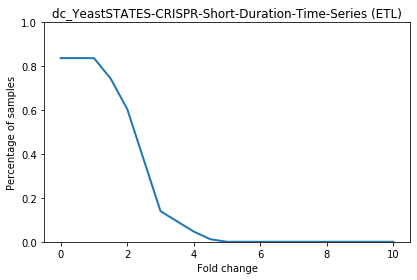

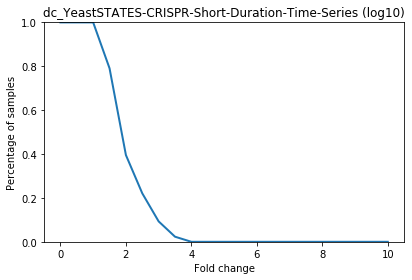

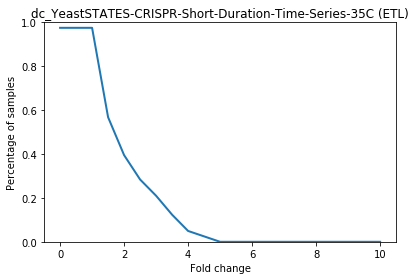

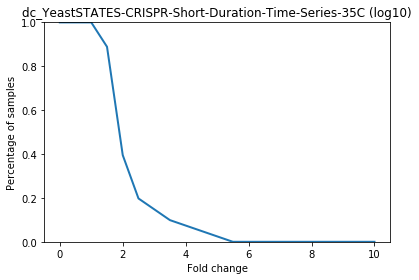

In [9]:
plot_above_threshold(all_summaries)


In [10]:
for r,s in all_summaries.items():
    print(r)
    print(len(s.index))

/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_etl_stats_wasserstein_dists.csv
86
/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv
86
/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032_fc_etl_stats_wasserstein_dists.csv
81
/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200526015032_fc_raw_log10_stats_wasserstein_dists.csv
81


In [11]:
all_summaries["/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv"]

,wasserstein_min,wasserstein_median,wasserstein_max,sample_ids
"(SpheroControl, 0.0)",1.022509,1.100851,13.255881,[(sample.transcriptic.aq1dvh7dssh7ewe.experime...
"(UWBF_23970, 0.0)",1.068321,2.223347,14.342646,[(sample.transcriptic.aq1dvh7dsr67549.experime...
"(UWBF_24864, 0.0)",1.198717,3.288583,10.410320,[(sample.transcriptic.aq1dvh7dss4q9g6.experime...
"(UWBF_24926, 0.0)",1.402385,2.511627,3.824715,[(sample.transcriptic.aq1dvh7dsraqwme.experime...
"(UWBF_24926, 4e-06)",1.307667,2.172938,3.240691,[(sample.transcriptic.aq1dvh7dsr6754b.experime...
"(UWBF_24926, 1e-05)",1.120676,1.354200,2.573942,[(sample.transcriptic.aq1dvh7dsr7bb89.experime...
"(UWBF_24926, 2.5e-05)",1.157911,1.488644,1.879233,[(sample.transcriptic.aq1dvh7dsr7bb8b.experime...
"(UWBF_24926, 4e-05)",1.462256,1.876889,2.213695,[(sample.transcriptic.aq1dvh7dsr8fhc9.experime...
"(UWBF_24926, 5.9999999999999995e-05)",1.345842,1.782865,2.165033,[(sample.transcriptic.aq1dvh7dsr8fhcb.experime...
"(UWBF_24926, 8e-05)",1.450047,1.955493,2.584007,[(sample.transcriptic.aq1dvh7dsr9kqga.experime...


In [12]:
all_summaries_over_well = compute_summary(results_dir_short, meta_files, ["strain","inducer_concentration","well","experiment_id"], "timepoint", [18.0,24.0],identifier="_time_diff_well_")


In [13]:
all_summaries_over_well["/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv"]

,wasserstein_min,wasserstein_median,wasserstein_max,sample_ids
"(SpheroControl, 0.0, f2, experiment.transcriptic.r1dvbs7kdxq4md)",1.036726,1.036726,1.036726,[(sample.transcriptic.aq1dvmrawdpnxv4.experime...
"(SpheroControl, 0.0, f2, experiment.transcriptic.r1dvbs8vu72tbp)",1.046513,1.046513,1.046513,[(sample.transcriptic.aq1dvhcr6e7kkvd.experime...
"(SpheroControl, 0.0, f2, experiment.transcriptic.r1dvbsa7n5qwxe)",12.290537,12.290537,12.290537,[(sample.transcriptic.aq1dvh7dssh7ewe.experime...
"(UWBF_23970, 0.0, a2, experiment.transcriptic.r1dvbs7kdxq4md)",2.223347,2.223347,2.223347,[(sample.transcriptic.aq1dvmrawcr5tgb.experime...
"(UWBF_23970, 0.0, a2, experiment.transcriptic.r1dvbs8vu72tbp)",7.827113,7.827113,7.827113,[(sample.transcriptic.aq1dvhcr6da7nmh.experime...
"(UWBF_23970, 0.0, a2, experiment.transcriptic.r1dvbsa7n5qwxe)",1.410663,1.410663,1.410663,[(sample.transcriptic.aq1dvh7dsr67549.experime...
"(UWBF_23970, 0.0, g1, experiment.transcriptic.r1dvbs7kdxq4md)",1.414222,1.414222,1.414222,[(sample.transcriptic.aq1dvmrawdvbxha.experime...
"(UWBF_23970, 0.0, g1, experiment.transcriptic.r1dvbs8vu72tbp)",1.676458,1.676458,1.676458,[(sample.transcriptic.aq1dvhcr6ed9khj.experime...
"(UWBF_23970, 0.0, g1, experiment.transcriptic.r1dvbsa7n5qwxe)",1.146694,1.146694,1.146694,[(sample.transcriptic.aq1dvh7dsspvejk.experime...
"(UWBF_23970, 0.0, h1, experiment.transcriptic.r1dvbs7kdxq4md)",1.463462,1.463462,1.463462,[(sample.transcriptic.aq1dvmrawe2zx6j.experime...


In [14]:
all_summaries_without_well = compute_summary(results_dir_short, meta_files, ["strain","inducer_concentration","experiment_id"], "timepoint", [18.0,24.0],identifier="_time_diff_no_well_")


In [15]:
all_summaries_without_well["/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv"]

,wasserstein_min,wasserstein_median,wasserstein_max,sample_ids
"(SpheroControl, 0.0, experiment.transcriptic.r1dvbs7kdxq4md)",1.036726,1.036726,1.036726,[(sample.transcriptic.aq1dvmrawdpnxv4.experime...
"(SpheroControl, 0.0, experiment.transcriptic.r1dvbs8vu72tbp)",1.046513,1.046513,1.046513,[(sample.transcriptic.aq1dvhcr6e7kkvd.experime...
"(SpheroControl, 0.0, experiment.transcriptic.r1dvbsa7n5qwxe)",12.290537,12.290537,12.290537,[(sample.transcriptic.aq1dvh7dssh7ewe.experime...
"(UWBF_23970, 0.0, experiment.transcriptic.r1dvbs7kdxq4md)",1.414222,1.850468,5.968439,[(sample.transcriptic.aq1dvmrawcr5tgb.experime...
"(UWBF_23970, 0.0, experiment.transcriptic.r1dvbs8vu72tbp)",1.652942,2.039919,7.827113,[(sample.transcriptic.aq1dvhcr6da7nmh.experime...
"(UWBF_23970, 0.0, experiment.transcriptic.r1dvbsa7n5qwxe)",1.068321,1.284751,1.868547,[(sample.transcriptic.aq1dvh7dsr67549.experime...
"(UWBF_24864, 0.0, experiment.transcriptic.r1dvbs7kdxq4md)",1.884015,4.121835,7.835102,[(sample.transcriptic.aq1dvmrawda6set.experime...
"(UWBF_24864, 0.0, experiment.transcriptic.r1dvbs8vu72tbp)",1.581365,3.043262,7.613412,[(sample.transcriptic.aq1dvhcr6du8mk2.experime...
"(UWBF_24864, 0.0, experiment.transcriptic.r1dvbsa7n5qwxe)",1.198717,1.277433,1.373794,[(sample.transcriptic.aq1dvh7dss4q9g6.experime...
"(UWBF_24926, 0.0, experiment.transcriptic.r1dvbs7kdxq4md)",2.293159,2.293159,2.293159,[(sample.transcriptic.aq1dvmrawcvpkzg.experime...


In [16]:
all_summaries_inducer = compute_summary(results_dir_short, meta_files, ["strain","timepoint","experiment_id"], "inducer_concentration", [0.0,0.0004],identifier="_inducer_diff_")


In [17]:
all_summaries_inducer["/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv"]

,wasserstein_min,wasserstein_median,wasserstein_max,sample_ids
"(UWBF_24926, 18.0, experiment.transcriptic.r1dvbs7kdxq4md)",1.272493,1.272493,1.272493,[(sample.transcriptic.aq1dvmrawcvpkzg.experime...
"(UWBF_24926, 18.0, experiment.transcriptic.r1dvbs8vu72tbp)",1.374826,1.374826,1.374826,[(sample.transcriptic.aq1dvhcr6derf5n.experime...
"(UWBF_24926, 18.0, experiment.transcriptic.r1dvbsa7n5qwxe)",1.115535,1.115535,1.115535,[(sample.transcriptic.aq1dvh7dsraqwme.experime...
"(UWBF_24926, 20.0, experiment.transcriptic.r1dvbs7kdxq4md)",1.754784,1.754784,1.754784,[(sample.transcriptic.aq1dvn2sw3mvt7v.experime...
"(UWBF_24926, 20.0, experiment.transcriptic.r1dvbs8vu72tbp)",1.496925,1.496925,1.496925,[(sample.transcriptic.aq1dvhp5yz83xn5.experime...
"(UWBF_24926, 20.0, experiment.transcriptic.r1dvbsa7n5qwxe)",1.893505,1.893505,1.893505,[(sample.transcriptic.aq1dvhgvrgrkwrv.experime...
"(UWBF_24926, 22.0, experiment.transcriptic.r1dvbs7kdxq4md)",2.723522,2.723522,2.723522,[(sample.transcriptic.aq1dvnc7pntcnfe.experime...
"(UWBF_24926, 22.0, experiment.transcriptic.r1dvbs8vu72tbp)",2.602955,2.602955,2.602955,[(sample.transcriptic.aq1dvhyrzzk54gu.experime...
"(UWBF_24926, 22.0, experiment.transcriptic.r1dvbsa7n5qwxe)",3.308932,3.308932,3.308932,[(sample.transcriptic.aq1dvhtnng8m2fk.experime...
"(UWBF_24926, 24.0, experiment.transcriptic.r1dvbs7kdxq4md)",3.864943,3.864943,3.864943,[(sample.transcriptic.aq1dvnnsmr3qkye.experime...


In [18]:
#code to compare with controls

def get_control_ids(metadata_file):
    meta_df = load_csv(metadata_file)
    neg_controls = meta_df[meta_df["strain_name"].str.contains("negative")]["sample_id"].tolist()
    pos_controls = meta_df[meta_df["strain_name"].str.contains("positive")]["sample_id"].tolist()
    return meta_df,pos_controls+neg_controls


def compute_control_difference(results_file, meta_df, control_ids):
    '''
    results_file = Wasserstein results
    meta_df = metadata data frame
    control_ids = all sample ids for positive and negative controls
    '''
    res_df = load_csv(results_file)
    samp_id_order = get_samp_id_order(res_df)
    results = get_matrix(res_df)[:,1:]
    values={}
    for samp_id in meta_df["sample_id"]:
        dists = []
        for cid in control_ids:
            try: 
                val = get_index_pair_value(results,samp_id_order,samp_id,cid)
            except:
                # handle dropped samples in ETL
                # print("One of the two sample ids {} not found.".format([samp_id_init,samp_id_fin]))
                val = nan   
            dists.append(val)
        if dists:
            values[samp_id] = dists
    summary = pd.DataFrame.from_dict(values, orient='index',columns=control_ids)
    return summary
        

def compute_control_dist_summary(results_dir_contents, meta_files,identifier = "_control_diff_"):
    all_summaries = {}
    for results_file,metadata_file in zip(results_dir_contents,meta_files):
        meta_df, control_ids = get_control_ids(metadata_file)
        summary = compute_control_difference(results_file, meta_df, control_ids)
        fname = results_file.split("/")[-1].split(".")[0] + identifier + "summary_" + datetime + ".csv"
        save_summary(summary,fname)
        params = {"results_file" : results_file, "metadata_file" : metadata_file }
        fname = results_file.split("/")[-1].split(".")[0] + identifier + "params_" + datetime + ".csv"
        save_params(params,fname)
        all_summaries[results_file] = summary
    return all_summaries
  

In [19]:
all_summaries_controls = compute_control_dist_summary(results_dir_short, meta_files,identifier="_control_diff_")


In [20]:
all_summaries_controls["/home/jupyter/tacc-work/GIT/flow_cytometry_scoring/notebooks/20200617/dc_YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200526004800_fc_raw_log10_stats_wasserstein_dists.csv"]

,sample.transcriptic.aq1dvh7dsr67547.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvh7dssg38sg.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvh7dssad959.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvh7dss4q9g6.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvh7dss4q9g4.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvh7dsrjpahm.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvh7dsrjpahj.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvh7dsrbv4rd.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvh7dsrbv4rf.experiment.transcriptic.r1dvbsa7n5qwxe,sample.transcriptic.aq1dvhgvrgjwx4q.experiment.transcriptic.r1dvbsa7n5qwxe,...,sample.transcriptic.aq1dvmrawe2zx6j.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvn2sw3gbzpp.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvn2sw4pthyr.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvn2sw58ugx6.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvnc7pnntuxa.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvnc7ppszyya.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvnc7ppzu6rf.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvnnsmqw2mbb.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvnnsmseqwsp.experiment.transcriptic.r1dvbs7kdxq4md,sample.transcriptic.aq1dvnnsmsnj4ju.experiment.transcriptic.r1dvbs7kdxq4md
sample.transcriptic.aq1dvh7dssh7ewe.experiment.transcriptic.r1dvbsa7n5qwxe,17.789333,71.284077,67.901607,23.456011,70.697138,22.148654,20.806804,18.951889,22.571603,25.034273,...,3.750373,1.412529,5.477695,7.639018,1.351469,10.048781,6.709301,1.314628,6.148675,2.879566
sample.transcriptic.aq1dvh7dssbhf98.experiment.transcriptic.r1dvbsa7n5qwxe,7.772224,30.248671,28.807901,9.960502,29.999835,9.409671,8.985678,8.294973,9.578406,10.625610,...,1.861627,2.419474,2.580660,3.495893,2.644786,4.582642,3.117320,2.923932,2.895936,1.387222
sample.transcriptic.aq1dvhgvrhhf3gj.experiment.transcriptic.r1dvbsa7n5qwxe,2.800264,5.626298,5.423506,2.413338,5.653739,2.495011,2.845127,3.111699,2.538192,2.460262,...,3.601844,12.168117,2.636145,3.357286,13.941231,3.149931,3.013161,15.922146,3.100921,4.746412
sample.transcriptic.aq1dvhgvrhamvqg.experiment.transcriptic.r1dvbsa7n5qwxe,31.144283,124.798505,118.904937,41.073570,123.796638,38.750461,36.434619,33.186548,39.517780,43.819784,...,6.356260,2.007094,8.997918,13.020350,1.730217,17.409489,11.598467,1.451747,10.518064,4.760075
sample.transcriptic.aq1dvhtnnh2kdb9.experiment.transcriptic.r1dvbsa7n5qwxe,2.737728,5.708800,5.505418,2.371043,5.737206,2.450673,2.781594,3.042167,2.493062,2.436491,...,3.531916,11.905494,2.573278,3.270529,13.714417,3.065392,2.938650,15.663249,3.026524,4.659461
sample.transcriptic.aq1dvhtnnguwdp3.experiment.transcriptic.r1dvbsa7n5qwxe,31.373741,125.719622,119.778500,41.377232,124.709614,39.036786,36.703429,33.431686,39.809527,44.142569,...,6.413471,2.021759,9.061287,13.116216,1.746283,17.537626,11.693123,1.455499,10.595541,4.795109
sample.transcriptic.aq1dvj68hhw8abj.experiment.transcriptic.r1dvbsa7n5qwxe,2.850647,5.879327,5.674790,2.449949,5.913148,2.532990,2.896387,3.167707,2.576745,2.517980,...,3.443015,11.597839,2.594714,3.341798,13.288460,3.173539,2.979787,15.176689,3.046474,4.521507
sample.transcriptic.aq1dvj68hhpe4je.experiment.transcriptic.r1dvbsa7n5qwxe,19.775818,79.195192,75.456008,26.065890,78.562588,24.591577,23.125444,21.075382,25.078592,27.809042,...,4.356525,1.665973,6.033324,8.724969,1.551657,11.452641,7.715615,1.366295,7.065219,3.278062
sample.transcriptic.aq1dvh7dsr6754b.experiment.transcriptic.r1dvbsa7n5qwxe,1.409653,5.001477,4.748706,1.795672,4.960252,1.693098,1.461462,1.358281,1.663017,1.771431,...,3.945965,12.865104,2.818024,1.949665,15.534560,1.456951,2.162398,17.741884,2.398687,5.280395
sample.transcriptic.aq1dvh7dsr67549.experiment.transcriptic.r1dvbsa7n5qwxe,23.092280,92.5365